### Introduction/Business Problem

The following project is aimed to find out where in the city of San Francisco would it be best to open or build a new bar for it to achieve its maximum success. We will look at what area is safest and most popular for the bar to thrive. Anyone that is looking to a open a bar in San Francisco or someone looking for a bar to visit can benefit from this analysis

### Data Section

Public datasets from San Francisco will be used alongside Foursquare API. We will be using San Francisco Registered Business Data to help locate the number and type of business in each area, San Francisco Crime Data to observe which neighborhood is safest to establish a new bar, and Foursquare API Data for access to venue data.

### Methodology

We are going to start by importing libraries that will be necessary

In [4]:
import numpy as np # library to handle data in a vectorized manner

import requests # library to handle requests
import pandas as pd # library for data analsysis

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

from geopy.geocoders import Nominatim

from IPython.display import Image 
from IPython.core.display import HTML

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

Solving environment: done

# All requested packages already installed.



In [6]:

CLIENT_ID = 'PBE4VCL2GCJ3XFZ3ITJTENGSXIXBA5SZGMSR50BTFI1UD5BX'
CLIENT_SECRET = '0RGY5AAY3FT250CU2BHOU4SNUZCIZPETZCHH0SZZYFUMIZ3V'
VERSION = '20180605'

In [18]:
business = pd.read_csv('https://data.sfgov.org/api/views/g8m3-pdis/rows.csv?accessType=DOWNLOAD')
print(business.shape)
business.head()

(260518, 36)


,Location Id,Business Account Number,Ownership Name,DBA Name,Street Address,City,State,Source Zipcode,Business Start Date,Business End Date,Location Start Date,Location End Date,Mail Address,Mail City,Mail Zipcode,Mail State,NAICS Code,NAICS Code Description,Parking Tax,Transient Occupancy Tax,LIC Code,LIC Code Description,Supervisor District,Neighborhoods - Analysis Boundaries,Business Corridor,Business Location,SF Find Neighborhoods,Current Police Districts,Current Supervisor Districts,Analysis Neighborhoods,DELETE - Zip Codes,DELETE - Fire Prevention Districts,DELETE - Supervisor Districts,DELETE - Current Police Districts,DELETE - Neighborhoods,DELETE - Police Districts
0,0404143-01-999,404143,Gepsr Llc,Entertainment Partners,Po Box 7837,Burbank,CA,91510.0,08/30/2006,02/21/2017,08/30/2006,02/21/2017,NaN,NaN,NaN,NaN,NaN,NaN,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1121337-09-161,1058392,"Bash, Inc.","Bash, Inc.",764 54th St.,Oakland,CA,94609.0,09/28/2016,09/30/2016,09/28/2016,09/30/2016,NaN,NaN,NaN,NaN,NaN,NaN,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1122247-10-161,1058834,Edgar Barrero,Edgar Barrero,5466 Roundtree Dr A,Concord,CA,94521.0,05/25/2016,05/30/2018,05/25/2016,05/30/2018,NaN,NaN,NaN,NaN,NaN,NaN,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1145483-05-171,1069805,Elmer Bungay,Elmer Bungay,517 Heath St,Milpitas,CA,95035.0,05/05/2017,05/05/2018,05/05/2017,05/05/2018,NaN,NaN,NaN,NaN,NaN,NaN,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1107771-08-161,1051654,Uber,Uber,414 A St,Daly City,CA,94014.0,01/01/2016,07/31/2018,01/01/2016,07/31/2018,NaN,NaN,NaN,NaN,NaN,NaN,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [19]:
#just pull the columns we need
business2 = business[['Business Start Date','DBA Name', 'Neighborhoods - Analysis Boundaries']].copy()

#drop null values
business3 = business2.dropna()

#convert business start date to datetime
business3['Business Start Date'] = business3['Business Start Date'].astype('datetime64[ns]') 

#let's just look at areas that have seen the most businesses start in the last decade.
business4 = business3.loc[business3['Business Start Date'] > '2010-01-01']

#let's also rename 'Neighborhoods - Analysis Boundaries' to just be 'Neighborhoods'
business4.rename(columns={'Neighborhoods - Analysis Boundaries': 'Neighborhood'}, inplace = True)

#let's do the same thing for the business name
business4.rename(columns={'DBA Name': 'Business Name'}, inplace = True)

business4.head()

/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/conda/envs/Python36/lib/python3.6/site-packages/pandas/core/frame.py:4025: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


,Business Start Date,Business Name,Neighborhood
5,2019-07-31,L Amour Spa,Chinatown
74,2019-02-10,Imaginary Menagerie,Mission
78,2018-01-01,Tal Yeshanov,Mission
81,2016-01-08,Zhen Xuan Li,Chinatown
84,2016-08-01,San Fransisco,South of Market


In [20]:
#Count the number of businesses in each neighborhood by grouping the data
business5 = business4.groupby('Neighborhood', as_index=False).count()
business5.reset_index()
#let's get rid of the business start date, we won't be needing it anymore
business5.drop(columns = 'Business Start Date',inplace = True)
#rename our "business name" column to "Businesses" to reflect the count per neighborhood
business5.rename(columns={'Business Name': 'Businesses'}, inplace = True)
#and sort the data
business6 = business5.sort_values(by= ['Businesses'], ascending = False).head(10)
business6.reset_index(drop=True)
business6


,Neighborhood,Businesses
5,Financial District/South Beach,12222
18,Mission,6660
33,South of Market,5765
34,Sunset/Parkside,4398
0,Bayview Hunters Point,3684
25,Outer Richmond,2911
16,Marina,2756
2,Castro/Upper Market,2695
9,Hayes Valley,2526
39,West of Twin Peaks,2522


In [21]:
#for reference, here is every neighborhood in SF as well as the count of registered businesses
business7 = business5.sort_values(by= ['Businesses'], ascending = False)
business7.reset_index(drop=True)
print(business7.shape)
business7

(41, 2)


,Neighborhood,Businesses
5,Financial District/South Beach,12222
18,Mission,6660
33,South of Market,5765
34,Sunset/Parkside,4398
0,Bayview Hunters Point,3684
25,Outer Richmond,2911
16,Marina,2756
2,Castro/Upper Market,2695
9,Hayes Valley,2526
39,West of Twin Peaks,2522


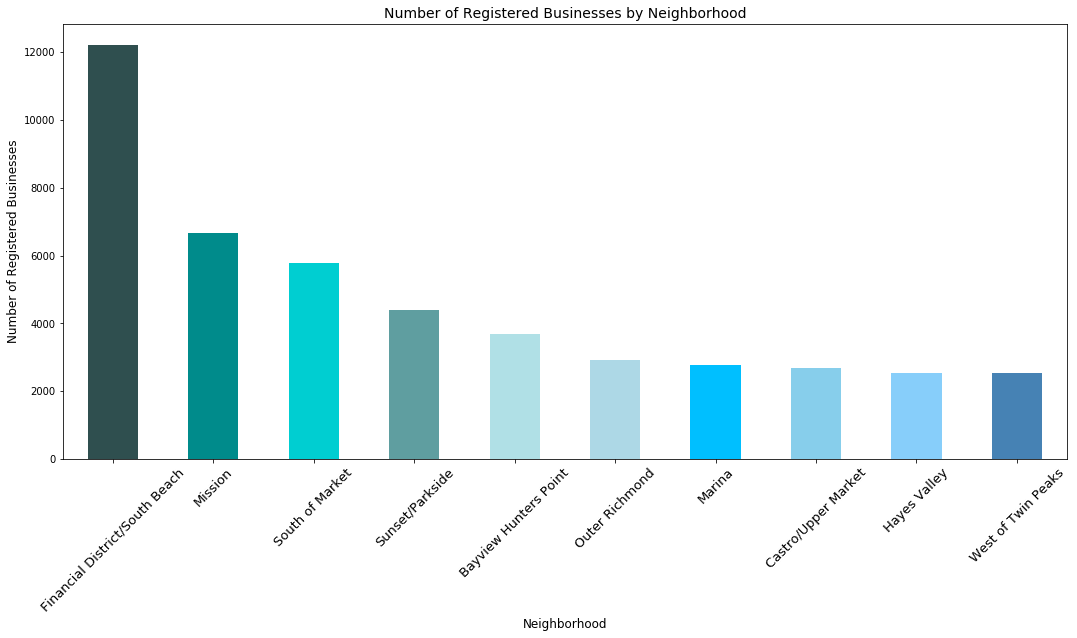

In [22]:
%matplotlib inline 

import matplotlib as mpl
import matplotlib.pyplot as plt


business6.plot.bar(x = 'Neighborhood', y = 'Businesses', title = "Number of Registered Businesses by Neighborhood", legend = None, rot= 45, figsize = (18, 8), color=['darkslategray','darkcyan','darkturquoise','cadetblue', 'powderblue','lightblue','deepskyblue','skyblue','lightskyblue','steelblue'])
plt.ylabel('Number of Registered Businesses', fontsize=12)
plt.xticks(fontsize=13)
plt.xlabel('Neighborhood', fontsize=12)
plt.title('Number of Registered Businesses by Neighborhood', fontsize = 14)
plt.show()


In [23]:
crime = pd.read_csv('https://data.sfgov.org/api/views/wg3w-h783/rows.csv?accessType=DOWNLOAD')
print(crime.shape)
crime.head()

(371817, 36)


,Incident Datetime,Incident Date,Incident Time,Incident Year,Incident Day of Week,Report Datetime,Row ID,Incident ID,Incident Number,CAD Number,Report Type Code,Report Type Description,Filed Online,Incident Code,Incident Category,Incident Subcategory,Incident Description,Resolution,Intersection,CNN,Police District,Analysis Neighborhood,Supervisor District,Latitude,Longitude,point,SF Find Neighborhoods,Current Police Districts,Current Supervisor Districts,Analysis Neighborhoods,HSOC Zones as of 2018-06-05,OWED Public Spaces,Central Market/Tenderloin Boundary Polygon - Updated,Parks Alliance CPSI (27+TL sites),ESNCAG - Boundary File,"Areas of Vulnerability, 2016"
0,2020/05/12 05:45:00 PM,2020/05/12,17:45,2020,Tuesday,2020/05/13 09:46:00 AM,92897328150,928973,206082743,NaN,II,Coplogic Initial,True,28150,Malicious Mischief,Vandalism,"Malicious Mischief, Vandalism to Property",Open or Active,NaN,NaN,Bayview,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020/05/19 09:00:00 PM,2020/05/19,21:00,2020,Tuesday,2020/05/20 05:43:00 PM,92899306244,928993,206082709,NaN,II,Coplogic Initial,True,6244,Larceny Theft,Larceny - From Vehicle,"Theft, From Locked Vehicle, >$950",Open or Active,NaN,NaN,Southern,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2020/05/16 06:00:00 PM,2020/05/16,18:00,2020,Saturday,2020/05/16 10:26:00 PM,92902428150,929024,206083296,NaN,II,Coplogic Initial,True,28150,Malicious Mischief,Vandalism,"Malicious Mischief, Vandalism to Property",Open or Active,NaN,NaN,Mission,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2020/03/30 12:00:00 AM,2020/03/30,00:00,2020,Monday,2020/05/04 11:47:00 AM,92905305073,929053,206062193,NaN,IS,Coplogic Supplement,True,5073,Burglary,Burglary - Other,"Burglary, Other Bldg., Unlawful Entry",Open or Active,NaN,NaN,Mission,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2020/02/03 02:45:00 PM,2020/02/03,14:45,2020,Monday,2020/02/03 05:50:00 PM,89881675000,898816,200085557,200342870.0,II,Initial,NaN,75000,Missing Person,Missing Person,Found Person,Open or Active,20TH AVE \ WINSTON DR,33719000.0,Taraval,Lakeshore,7.0,37.72695,-122.476039,"(37.72694991292525, -122.47603947349434)",41.0,10.0,8.0,16.0,NaN,NaN,NaN,NaN,NaN,2.0


In [24]:
#take just the columns we need
crime1 = crime[['Analysis Neighborhood','Incident Category', 'Incident Date']]

#drop all null values
crime2 = crime1.dropna()

#convert incident date to datetime
crime2['Incident Date'] = crime2['Incident Date'].astype('datetime64[ns]') 

#filter to just crimes in the last 5 years, as the neighborhoods in san francisco are rapidly changing and being gentrified, we want data that is relevant to today's crime.
crime3 = crime2.loc[crime2['Incident Date'] > '2015-01-01']

#There's lots of scary crimes out there, but let's make sure we aren't factoring in non-criminal police reports, because that data will pollute our insights.
crime4 = crime3.loc[crime3['Incident Category'] != 'Non-Criminal']

#change the name of 'Analysis Neighborhood' to 'Neighborhood'
crime4.rename(columns={'Analysis Neighborhood': 'Neighborhood'}, inplace = True)

crime4.head(20)

/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/conda/envs/Python36/lib/python3.6/site-packages/pandas/core/frame.py:4025: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


,Neighborhood,Incident Category,Incident Date
4,Lakeshore,Missing Person,2020-02-03
6,Mission,Stolen Property,2020-02-03
9,Pacific Heights,Miscellaneous Investigation,2020-01-05
10,Financial District/South Beach,Miscellaneous Investigation,2020-02-03
11,Castro/Upper Market,Offences Against The Family And Children,2020-01-16
13,Castro/Upper Market,Other Miscellaneous,2020-01-23
16,Twin Peaks,Lost Property,2020-01-10
17,Bayview Hunters Point,Larceny Theft,2020-02-03
18,Pacific Heights,Miscellaneous Investigation,2020-01-31
19,Pacific Heights,Larceny Theft,2020-01-31


In [25]:
#count the number of crimes in each neighborhood
crime5 = crime4.groupby('Neighborhood', as_index=False).count()
#get rid of Incident Date
crime5.drop(columns = 'Incident Date',inplace = True)
#rename our column to reflect the counts of incidents
crime5.rename(columns={'Incident Category': 'Incidents'}, inplace = True)
#and sort our values
crime6 = crime5.sort_values(by= ['Incidents'], ascending = False)
crime7 = crime6.head(10)
crime7

,Neighborhood,Incidents
18,Mission,37803
35,Tenderloin,33612
5,Financial District/South Beach,30364
33,South of Market,28231
0,Bayview Hunters Point,19886
40,Western Addition,11017
22,North Beach,10141
2,Castro/Upper Market,10123
20,Nob Hill,9706
34,Sunset/Parkside,9407


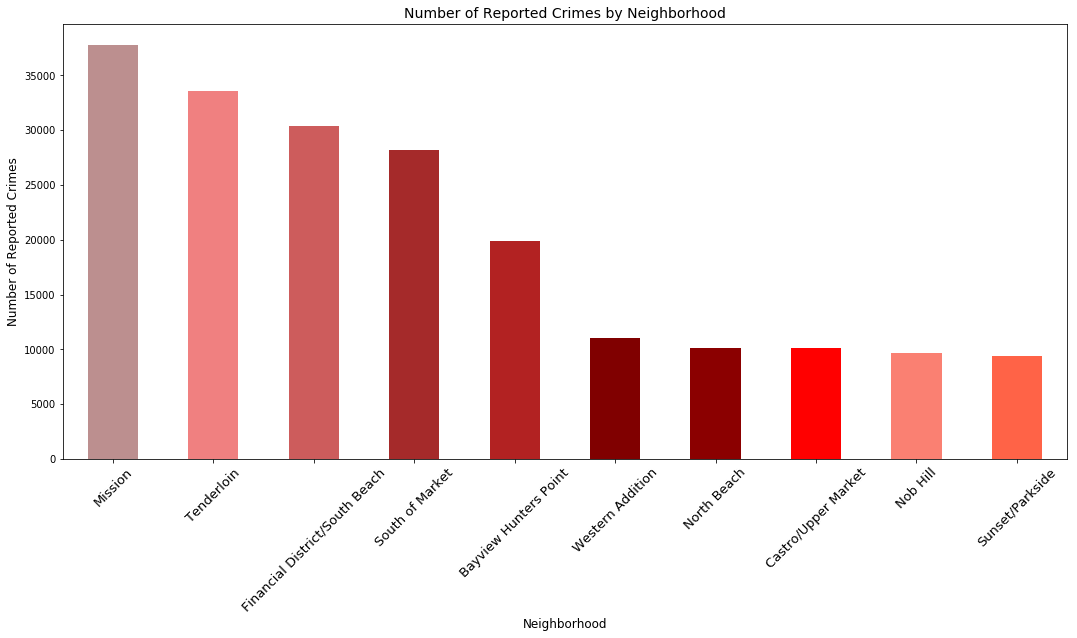

In [27]:
crime7.plot.bar(x = 'Neighborhood', y = 'Incidents', title = "Crime Incidents by Neighborhood", legend = None, rot= 45, figsize = (18, 8), color=['rosybrown', 'lightcoral', 'indianred', 'brown', 'firebrick', 'maroon', 'darkred', 'red', 'salmon', 'tomato'])
plt.ylabel('Number of Reported Crimes', fontsize=12)
plt.xticks(fontsize=13)
plt.xlabel('Neighborhood', fontsize=12)
plt.title('Number of Reported Crimes by Neighborhood', fontsize = 14)
plt.show()

In [28]:
#get a dataframe with the 5 highest incident neighborhoods
crime8 = crime7.head(5)
crime8

,Neighborhood,Incidents
18,Mission,37803
35,Tenderloin,33612
5,Financial District/South Beach,30364
33,South of Market,28231
0,Bayview Hunters Point,19886


In [29]:

'''start by merging the datasets and making a new dataset that incldues the neighborhoods 
which wereamong the top 10 for businesses AND are amond the top 5 for crime '''
Overlap = business6.merge(crime8, on=['Neighborhood'])
'''then take this joined dataframe and remove all common values from your list of top 10 
neighborhoods for businesses'''
SF_Neighborhoods = business6[(~business6.Neighborhood.isin(Overlap.Neighborhood))]
'''and what you have is the top neighborhoods for businesses that are NOT the top 
neighborhoods for crime'''
SF_Neighborhoods.head()

,Neighborhood,Businesses
34,Sunset/Parkside,4398
25,Outer Richmond,2911
16,Marina,2756
2,Castro/Upper Market,2695
9,Hayes Valley,2526


In [30]:
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="SF_explorer")
SF_Neighborhoods['Coordinates'] = SF_Neighborhoods['Neighborhood'].apply(geolocator.geocode).apply(lambda x: (x.latitude, x.longitude))
SF_Neighborhoods

/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


,Neighborhood,Businesses,Coordinates
34,Sunset/Parkside,4398,"(42.755607350000005, -81.19148009899396)"
25,Outer Richmond,2911,"(44.108805, -69.798725)"
16,Marina,2756,"(43.5139149, 16.1092196)"
2,Castro/Upper Market,2695,"(-34.6200719, -58.4205112)"
9,Hayes Valley,2526,"(37.7766853, -122.4229361)"
39,West of Twin Peaks,2522,"(37.75464, -122.44648)"


In [31]:
SF_Neighborhoods.loc[SF_Neighborhoods.Neighborhood == 'Sunset/Parkside' , 'Coordinates'] = "(37.751616, -122.490810)"
SF_Neighborhoods.loc[SF_Neighborhoods.Neighborhood == 'Outer Richmond' , 'Coordinates'] = "(37.780001, -122.490229)"
SF_Neighborhoods.loc[SF_Neighborhoods.Neighborhood == 'Castro/Upper Market' , 'Coordinates'] = "(37.762932, -122.435395)"
SF_Neighborhoods.loc[SF_Neighborhoods.Neighborhood == 'West of Twin Peaks' , 'Coordinates'] = "(37.739871, -122.460106)"
SF_Neighborhoods.loc[SF_Neighborhoods.Neighborhood == 'Marina' , 'Coordinates'] = "(37.801406, -122.439718)"
SF_Neighborhoods.loc[SF_Neighborhoods.Neighborhood == 'Hayes Valley' , 'Coordinates'] = "(37.776685, -122.422936)"
SF_Neighborhoods

/opt/conda/envs/Python36/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


,Neighborhood,Businesses,Coordinates
34,Sunset/Parkside,4398,"(37.751616, -122.490810)"
25,Outer Richmond,2911,"(37.780001, -122.490229)"
16,Marina,2756,"(37.801406, -122.439718)"
2,Castro/Upper Market,2695,"(37.762932, -122.435395)"
9,Hayes Valley,2526,"(37.776685, -122.422936)"
39,West of Twin Peaks,2522,"(37.739871, -122.460106)"


In [32]:
SF = SF_Neighborhoods.merge(crime6, on=['Neighborhood'])
SF.rename(columns={'Incidents':'Crimes'}, inplace = True)
SF = SF[['Neighborhood', 'Businesses', 'Crimes','Coordinates']]
SF['Coordinates'].to_string()
SF[['Latitude','Longitude']] = SF['Coordinates'].str.strip('(').str.strip(')').str.split(', ', expand=True)

SF

,Neighborhood,Businesses,Crimes,Coordinates,Latitude,Longitude
0,Sunset/Parkside,4398,9407,"(37.751616, -122.490810)",37.751616,-122.490810
1,Outer Richmond,2911,7369,"(37.780001, -122.490229)",37.780001,-122.490229
2,Marina,2756,8204,"(37.801406, -122.439718)",37.801406,-122.439718
3,Castro/Upper Market,2695,10123,"(37.762932, -122.435395)",37.762932,-122.435395
4,Hayes Valley,2526,9301,"(37.776685, -122.422936)",37.776685,-122.422936
5,West of Twin Peaks,2522,6606,"(37.739871, -122.460106)",37.739871,-122.460106


In [36]:
#foursquare data analysis
def getNearbyVenues(names, latitudes, longitudes, radius=800, LIMIT = 100):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [37]:
SF_venues = getNearbyVenues(names=SF['Neighborhood'],
                                   latitudes=SF['Latitude'],
                                   longitudes=SF['Longitude']
                                  )

Sunset/Parkside
Outer Richmond
Marina
Castro/Upper Market
Hayes Valley
West of Twin Peaks


In [38]:

print(SF_venues.shape)
SF_venues.head()

(477, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Sunset/Parkside,37.751616,-122.490810,TJ Brewed Tea and Real Fruit (TJ Cups),37.753561,-122.490028,Bubble Tea Shop
1,Sunset/Parkside,37.751616,-122.490810,Donut Time,37.753651,-122.489439,Donut Shop
2,Sunset/Parkside,37.751616,-122.490810,S&T Hong Kong Seafood,37.753702,-122.491278,Dim Sum Restaurant
3,Sunset/Parkside,37.751616,-122.490810,Polly Ann Ice Cream,37.753454,-122.497765,Ice Cream Shop
4,Sunset/Parkside,37.751616,-122.490810,Sunset Recreation Center,37.757310,-122.487072,Playground


In [39]:
#take a look at how many venues were pulled for each neighborhood
SF_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Castro/Upper Market,100,100,100,100,100,100
Hayes Valley,100,100,100,100,100,100
Marina,100,100,100,100,100,100
Outer Richmond,93,93,93,93,93,93
Sunset/Parkside,33,33,33,33,33,33
West of Twin Peaks,51,51,51,51,51,51


In [40]:

#the number of unique types of venues pulled
print('There are {} uniques categories.'.format(len(SF_venues['Venue Category'].unique())))

There are 169 uniques categories.


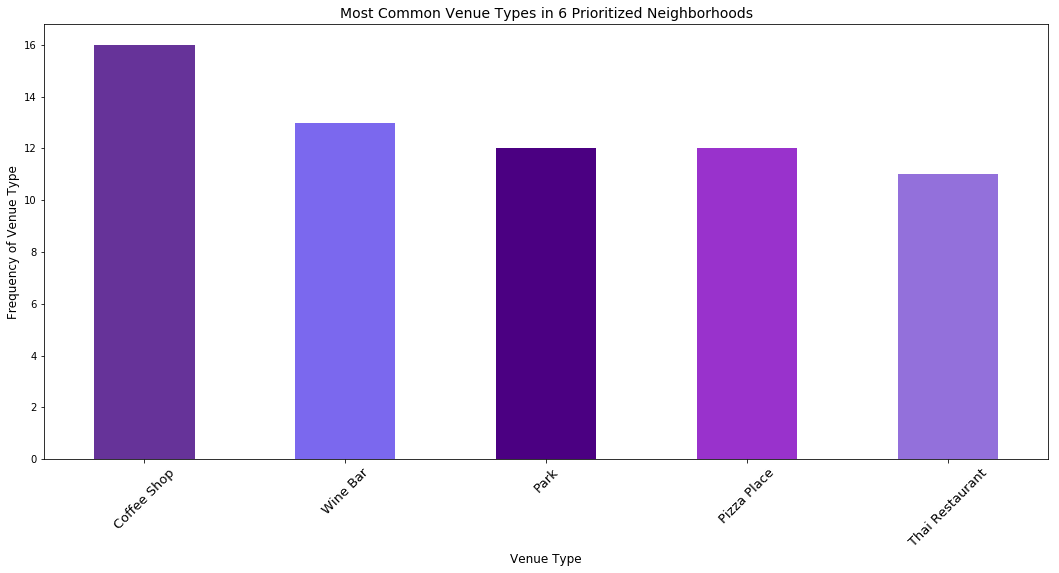

In [41]:

SF_top_venues = SF_venues.groupby('Venue Category', as_index = False).count().sort_values('Neighborhood', ascending = False).head(5)
SF_top_venues = SF_top_venues[['Venue Category','Neighborhood']]
SF_top_venues.rename(columns={'Neighborhood': 'Frequency'}, inplace = True)
SF_top_venues.plot.bar(x='Venue Category', y='Frequency', legend = None, title = "Most common venue types in 6 prioritized neighborhoods", rot= 45, figsize = (18, 8), color=['rebeccapurple','mediumslateblue','indigo','darkorchid','mediumpurple'])
plt.ylabel('Frequency of Venue Type', fontsize=12)
plt.xticks(fontsize=13)
plt.xlabel('Venue Type', fontsize=12)
plt.title('Most Common Venue Types in 6 Prioritized Neighborhoods', fontsize = 14)
plt.show()

In [42]:
# one hot encoding
SF_onehot = pd.get_dummies(SF_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
SF_onehot['Neighborhood'] = SF_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [SF_onehot.columns[-1]] + list(SF_onehot.columns[:-1])
SF_onehot = SF_onehot[fixed_columns]

SF_onehot.head()

,Neighborhood,Accessories Store,Alternative Healer,American Restaurant,Antique Shop,Arcade,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Beer Bar,Beer Garden,Bike Shop,Board Shop,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Burger Joint,Burmese Restaurant,Burrito Place,Bus Station,Butcher,Café,Camera Store,Candy Store,Chinese Restaurant,Churrascaria,Clothing Store,Cocktail Bar,Coffee Shop,Comic Shop,Community Center,Concert Hall,Convenience Store,Cosmetics Shop,Creperie,Cupcake Shop,Cycle Studio,Dance Studio,Deli / Bodega,Dessert Shop,Dim Sum Restaurant,Diner,Dive Bar,Dog Run,Donut Shop,Dumpling Restaurant,Electronics Store,Elementary School,Event Space,Farmers Market,Field,Flea Market,Flower Shop,Food & Drink Shop,French Restaurant,Frozen Yogurt Shop,Furniture / Home Store,Garden Center,Gastropub,Gay Bar,German Restaurant,Gift Shop,Golf Course,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Hardware Store,Health & Beauty Service,Hill,Historic Site,History Museum,Hotel,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Italian Restaurant,Japanese Restaurant,Jazz Club,Juice Bar,Kids Store,Kitchen Supply Store,Korean Restaurant,Lake,Liquor Store,Lounge,Martial Arts School,Massage Studio,Mediterranean Restaurant,Mexican Restaurant,Middle School,Monument / Landmark,Moroccan Restaurant,Motel,Mountain,Movie Theater,Museum,Music School,Music Store,Music Venue,Nail Salon,New American Restaurant,Newsstand,Noodle House,Opera House,Optical Shop,Organic Grocery,Outdoor Sculpture,Park,Pedestrian Plaza,Performing Arts Venue,Pet Café,Pet Store,Pharmacy,Pilates Studio,Pizza Place,Playground,Plaza,Poke Place,Pool,Pub,Ramen Restaurant,Record Shop,Recreation Center,Restaurant,Russian Restaurant,Salad Place,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,Seafood Restaurant,Shanghai Restaurant,Shipping Store,Southern / Soul Food Restaurant,Souvlaki Shop,Spa,Spanish Restaurant,Sporting Goods Shop,Stationery Store,Steakhouse,Supermarket,Sushi Restaurant,Szechuan Restaurant,Taco Place,Taiwanese Restaurant,Tea Room,Tennis Court,Thai Restaurant,Theater,Thrift / Vintage Store,Tiki Bar,Toy / Game Store,Trail,Tree,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wine Bar,Wine Shop,Yoga Studio
0,Sunset/Parkside,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Sunset/Parkside,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Sunset/Parkside,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Sunset/Parkside,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Sunset/Parkside,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

In [43]:

#examine shape of new dataframe
SF_onehot.shape

(477, 170)

In [44]:
#now group the data
SF_grouped = SF_onehot.groupby('Neighborhood').mean().reset_index()
print(SF_grouped.shape)
SF_grouped


(6, 170)


,Neighborhood,Accessories Store,Alternative Healer,American Restaurant,Antique Shop,Arcade,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Beer Bar,Beer Garden,Bike Shop,Board Shop,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Burger Joint,Burmese Restaurant,Burrito Place,Bus Station,Butcher,Café,Camera Store,Candy Store,Chinese Restaurant,Churrascaria,Clothing Store,Cocktail Bar,Coffee Shop,Comic Shop,Community Center,Concert Hall,Convenience Store,Cosmetics Shop,Creperie,Cupcake Shop,Cycle Studio,Dance Studio,Deli / Bodega,Dessert Shop,Dim Sum Restaurant,Diner,Dive Bar,Dog Run,Donut Shop,Dumpling Restaurant,Electronics Store,Elementary School,Event Space,Farmers Market,Field,Flea Market,Flower Shop,Food & Drink Shop,French Restaurant,Frozen Yogurt Shop,Furniture / Home Store,Garden Center,Gastropub,Gay Bar,German Restaurant,Gift Shop,Golf Course,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Hardware Store,Health & Beauty Service,Hill,Historic Site,History Museum,Hotel,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Italian Restaurant,Japanese Restaurant,Jazz Club,Juice Bar,Kids Store,Kitchen Supply Store,Korean Restaurant,Lake,Liquor Store,Lounge,Martial Arts School,Massage Studio,Mediterranean Restaurant,Mexican Restaurant,Middle School,Monument / Landmark,Moroccan Restaurant,Motel,Mountain,Movie Theater,Museum,Music School,Music Store,Music Venue,Nail Salon,New American Restaurant,Newsstand,Noodle House,Opera House,Optical Shop,Organic Grocery,Outdoor Sculpture,Park,Pedestrian Plaza,Performing Arts Venue,Pet Café,Pet Store,Pharmacy,Pilates Studio,Pizza Place,Playground,Plaza,Poke Place,Pool,Pub,Ramen Restaurant,Record Shop,Recreation Center,Restaurant,Russian Restaurant,Salad Place,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,Seafood Restaurant,Shanghai Restaurant,Shipping Store,Southern / Soul Food Restaurant,Souvlaki Shop,Spa,Spanish Restaurant,Sporting Goods Shop,Stationery Store,Steakhouse,Supermarket,Sushi Restaurant,Szechuan Restaurant,Taco Place,Taiwanese Restaurant,Tea Room,Tennis Court,Thai Restaurant,Theater,Thrift / Vintage Store,Tiki Bar,Toy / Game Store,Trail,Tree,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wine Bar,Wine Shop,Yoga Studio
0,Castro/Upper Market,0.00,0.00,0.010000,0.000000,0.01,0.01,0.01,0.00,0.000000,0.000000,0.00,0.020000,0.000000,0.000000,0.000000,0.00,0.00,0.00,0.000000,0.010000,0.000000,0.000000,0.01,0.010000,0.010000,0.010000,0.000000,0.000000,0.000000,0.00,0.010000,0.01,0.01,0.000000,0.00,0.00,0.00,0.060000,0.00,0.00,0.01,0.000000,0.000000,0.000000,0.00,0.01,0.01,0.020000,0.020000,0.000000,0.010000,0.000000,0.02,0.000000,0.010000,0.00,0.000000,0.00,0.01,0.000000,0.000000,0.01,0.00,0.01,0.000000,0.00,0.01,0.00,0.09,0.00,0.00,0.000000,0.000000,0.020000,0.020000,0.010000,0.000000,0.00,0.02,0.01,0.01,0.01,0.00,0.010000,0.030000,0.01,0.010000,0.020000,0.00,0.02,0.00,0.00,0.000000,0.000000,0.010000,0.00,0.000000,0.00,0.020000,0.010000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.01,0.00,0.000000,0.00,0.000000,0.040000,0.00,0.000000,0.00,0.010000,0.00,0.00,0.040000,0.00,0.00,0.00,0.02,0.000000,0.01,0.010000,0.000000,0.01,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.00,0.010000,0.01,0.01,0.020000,0.000000,0.000000,0.000000,0.00,0.00,0.01,0.000000,0.00,0.00,0.01,0.000000,0.01,0.00,0.000000,0.000000,0.000000,0.040000,0.00,0.000000,0.000000,0.000000,0.010000,0.000000,0.00,0.000000,0.020000,0.01,0.01
1,Hayes Valley,0.01,0.00,0.000000,0.000000,0.00,0.00,0.00,0.00,0.000000,0.000000,0.01,0.030000,0.000000,0.010000,0.000000,0.01,0.01,0.00,0.000000,0.010000,0.030000,0.000000,0.00,0.000000,0.020000,0.010000,0.000000,0.000000,0.000000,0.01,0.020000,0.01,0.00,0.000000,0.01,0.02,0.03,0.030000,0.01,0.01,0.02,0.000000,0.000000,0.000000,0.00,0.00,0.01,0.000000,0.030000,0.000000,0.000000,0.000000,0.00,0.010000,0.000000,0.00,0.0000

In [45]:
#print each neighborhood with the top 5 most common venues
num_top_venues = 5

for hood in SF_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = SF_grouped[SF_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Castro/Upper Market----
                     venue  freq
0                  Gay Bar  0.09
1              Coffee Shop  0.06
2          Thai Restaurant  0.04
3  New American Restaurant  0.04
4                     Park  0.04


----Hayes Valley----
               venue  freq
0           Wine Bar  0.05
1             Bakery  0.03
2       Optical Shop  0.03
3  French Restaurant  0.03
4            Theater  0.03


----Marina----
                  venue  freq
0  Gym / Fitness Center  0.05
1        Cosmetics Shop  0.04
2              Wine Bar  0.04
3     French Restaurant  0.04
4    Italian Restaurant  0.04


----Outer Richmond----
                   venue  freq
0     Chinese Restaurant  0.08
1                   Café  0.06
2  Vietnamese Restaurant  0.04
3             Restaurant  0.03
4      Korean Restaurant  0.03


----Sunset/Parkside----
                 venue  freq
0   Chinese Restaurant  0.12
1           Playground  0.06
2  Japanese Restaurant  0.06
3   Dim Sum Restaurant  0.06
4         

In [46]:

def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [47]:

num_top_venues = 30

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = SF_grouped['Neighborhood']

for ind in np.arange(SF_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(SF_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,11th Most Common Venue,12th Most Common Venue,13th Most Common Venue,14th Most Common Venue,15th Most Common Venue,16th Most Common Venue,17th Most Common Venue,18th Most Common Venue,19th Most Common Venue,20th Most Common Venue,21th Most Common Venue,22th Most Common Venue,23th Most Common Venue,24th Most Common Venue,25th Most Common Venue,26th Most Common Venue,27th Most Common Venue,28th Most Common Venue,29th Most Common Venue,30th Most Common Venue
0,Castro/Upper Market,Gay Bar,Coffee Shop,New American Restaurant,Thai Restaurant,Park,Indian Restaurant,Gym,Dessert Shop,Wine Bar,Bakery,Seafood Restaurant,Mediterranean Restaurant,Pet Store,Juice Bar,Japanese Restaurant,Hill,Grocery Store,Dog Run,Deli / Bodega,Gym / Fitness Center,Historic Site,History Museum,Asian Restaurant,Hotel,Ice Cream Shop,Indie Movie Theater,Italian Restaurant,Liquor Store,Mexican Restaurant,Museum
1,Hayes Valley,Wine Bar,Optical Shop,Boutique,Dessert Shop,Coffee Shop,Cocktail Bar,Pizza Place,Theater,French Restaurant,New American Restaurant,Bakery,Bubble Tea Shop,Food & Drink Shop,Café,Performing Arts Venue,Sushi Restaurant,Clothing Store,Ice Cream Shop,Juice Bar,Park,Concert Hall,Italian Restaurant,Kids Store,Jazz Club,Massage Studio,Liquor Store,Lounge,Gym,Mexican Restaurant,Music School
2,Marina,Gym / Fitness Center,Wine Bar,French Restaurant,Italian Restaurant,Cosmetics Shop,Park,New American Restaurant,Taco Place,Electronics Store,Gym,Diner,Deli / Bodega,Coffee Shop,Sushi Restaurant,Salad Place,Sandwich Place,Ice Cream Shop,Playground,Thai Restaurant,Juice Bar,Mexican Restaurant,American Restaurant,Historic Site,Wine Shop,Health & Beauty Service,Hardware Store,Japanese Restaurant,Kitchen Supply Store,Motel,Greek Restaurant
3,Outer Richmond,Chinese Restaurant,Café,Vietnamese Restaurant,Restaurant,Playground,Pizza Place,Korean Restaurant,Thai Restaurant,Sushi Restaurant,Indian Restaurant,Seafood Restaurant,Japanese Restaurant,Bakery,Burger Joint,Coffee Shop,Bus Station,Deli / Bodega,Sandwich Place,Moroccan Restaurant,Burrito Place,Pharmacy,Bubble Tea Shop,Burmese Restaurant,Dumpling Restaurant,Noodle House,Italian Restaurant,Ramen Restaurant,Diner,New American Restaurant,Dim Sum Restaurant
4,Sunset/Parkside,Chinese Restaurant,Dim Sum Restaurant,Japanese Restaurant,Playground,Dessert Shop,Sandwich Place,Bus Station,Pool,Pizza Place,Coffee Shop,Optical Shop,Pharmacy,Brewery,Donut Shop,Elementary School,Middle School,Field,Lake,Ice Cream Shop,Gym,Bubble Tea Shop,Hardware Store,Bar,Baseball Field,Vietnamese Restaurant,Tennis Court,Bank,Bookstore,Farmers Market,Flower Shop
5,West of Twin Peaks,Burger Joint,Pizza Place,Park,Sandwich Place,Wine Bar,Italian Restaurant,Pharmacy,Mexican Restaurant,Coffee Shop,Nail Salon,Burrito Place,Pub,Café,Playground,Convenience Store,Indian Restaurant,Music Store,Brazilian Restaurant,Mountain,Monument / Landmark,Mediterranean Restaurant,Diner,Dive Bar,Frozen Yogurt Shop,Gym / Fitness Center,Gym,Grocery Store,Movie Theater,Greek Restaurant,Toy / Game Store


In [48]:

# set number of clusters
kclusters = 3

SF_grouped_clustering = SF_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(SF_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([1, 1, 1, 2, 0, 1], dtype=int32)

In [54]:
SF_merged = SF

In [55]:

# merge SF_grouped with SF_data to add latitude/longitude for each neighborhood
SF_merged = SF_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')


In [56]:

#also including the number of bars and restaurants that each neighborhood has in its top 10 most popular spots.
SF_merged["Bars and Restaurants"] = ""
SF_merged.loc[SF_merged.Neighborhood == 'Sunset/Parkside', 'Bars and Restaurants'] = .37
SF_merged.loc[SF_merged.Neighborhood == 'Outer Richmond', 'Bars and Restaurants'] = .6
SF_merged.loc[SF_merged.Neighborhood == 'Marina', 'Bars and Restaurants'] = .67
SF_merged.loc[SF_merged.Neighborhood == 'Castro/Upper Market', 'Bars and Restaurants'] = .37
SF_merged.loc[SF_merged.Neighborhood == 'West of Twin Peaks', 'Bars and Restaurants'] = .5
SF_merged.loc[SF_merged.Neighborhood == 'Hayes Valley', 'Bars and Restaurants'] = .5
SF_merged['Bars and Restaurants'].astype(int, inplace = True)

0    0
1    0
2    0
3    0
4    0
5    0
Name: Bars and Restaurants, dtype: int64

In [57]:
SF_merged['Latitude'] = SF_merged['Latitude'].astype(float)
SF_merged['Longitude'] = SF_merged['Longitude'].astype(float)
SF_merged['Cluster Labels'] = SF_merged['Cluster Labels'].astype(int)



SF_merged

KeyError: 'Cluster Labels'

/opt/conda/envs/Python36/lib/python3.6/site-packages/pandas/core/frame.py:4025: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)
/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


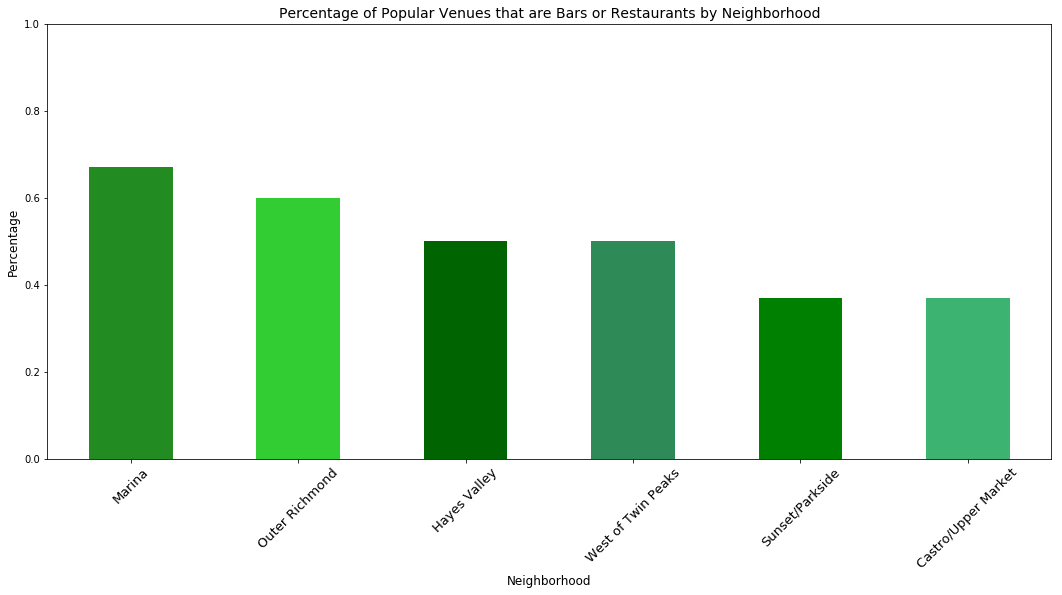

In [58]:
SF_rb = SF_merged[['Neighborhood','Bars and Restaurants']]
SF_rb.rename(columns={'Bars and Restaurants': 'Frequency'}, inplace = True)
SF_rb.sort_values('Frequency', inplace = True, ascending = False)
SF_rb.plot.bar(x='Neighborhood',y ='Frequency', rot = 45, figsize = (18, 8), legend = None, color = ['forestgreen','limegreen','darkgreen','seagreen','green','mediumseagreen'])
plt.ylabel('Percentage', fontsize=12)
plt.xticks(fontsize=13)
plt.xlabel('Neighborhood', fontsize=12)
plt.ylim(0,1)
plt.title('Percentage of Popular Venues that are Bars or Restaurants by Neighborhood', fontsize = 14)
plt.show()

In [59]:

address = 'San Francisco, California'

geolocator = Nominatim(user_agent="SF_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of San Francisco are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of San Francisco are 37.7790262, -122.4199061.


In [60]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=13)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(.7, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# # add markers to the map
markers_colors = []
for lat, lon, poi, cluster, bars in zip(SF_merged['Latitude'], SF_merged['Longitude'], SF_merged['Neighborhood'], SF_merged['Cluster Labels'], SF_merged['Bars and Restaurants']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=35*bars,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=1).add_to(map_clusters)
       
map_clusters

KeyError: 'Cluster Labels'

Results and Discussion

By using information from datasets of business registrations and crime rates, as well as Foursquare, we have narrowed down neighborhood options to open up a bar in one of six areas in San Francisco

The most common venues in our areas of interest were discovered to be coffee shops, wine bars, parks, pizza places, and Chinese restaurants.

Clustering neighborhoods based on their most popular venues grouped West of Twin Peaks alongside with Castro, Hayes Valley, and Marine. Meanwhile, outer Richmond was placed in its own cluster as was Sunset.

Castro and Hayes Valley are the two neighborhoods where bars are the most popular venues.

Because Castro is the neighborhood that has the most crime rates out of the six areas we looked at, I have come to the conclusion that Hayes Valley is the neighborhood where a new bar should be opened because it is the 3rd out of 6 in crime rates and has much of a bar scene.